# Introduction to JUDI

JUDI is a framework for large-scale seismic modeling and inversion and designed to enable rapid translations of algorithms to fast and efficient code that scales to industry-size 3D problems. The focus of the package lies on seismic modeling as well as PDE-constrained optimization such as full-waveform inversion (FWI) and imaging (LS-RTM). Wave equations in JUDI are solved with [Devito](https://www.devitoproject.org), a Python domain-specific language for automated finite-difference (FD) computations. JUDI's modeling operators can also be used as layers in (convolutional) neural networks to implement physics-augmented deep learning algorithms. For this, check out JUDI's deep learning extension [JUDI4Flux](https://github.com/slimgroup/JUDI4Flux.jl).

In [1]:
using JUDI, PyPlot, LinearAlgebra

# Physical problem setup
## Grid
JUDI relies on a cartesian grid for modeling and inversion. We start by defining the parameters needed for a cartesian grid:
 - A shape
 - A grid spacing in each direction
 - An origin

In [2]:
shape = (201, 201) # Number of gridpoints nx, nz
spacing = (10.0, 10.0) # #n meters here
origin = (0.0, 0.0) # In meters as well

(0.0, 0.0)

## Physical object

JUDI defines a few basic types to handle physical object such as the velocity model. The type `PhyisicalParameter` is an abstract vector and behaves as a standard vector.
A `PhysicalParameter` can be constructed in various ways but always require the origin `o` and grid spacing `d` that
cannot be infered from the array.

    PhysicalParameter(v::Array{vDT}, d, o) where `v` is an n-dimensional array and n=size(v)

    PhysicalParameter(n, d, o; vDT=Float32) Creates a zero PhysicalParameter

    PhysicalParameter(v::Array{vDT}, A::PhysicalParameter) Creates a PhysicalParameter from the Array `v` with n, d, o from `A`

    PhysicalParameter(v::Array{vDT, N}, n::Tuple, d::Tuple, o::Tuple) where `v` is a vector or nd-array that is reshaped into shape `n`

    PhysicalParameter(v::vDT, n::Tuple, d::Tuple, o::Tuple) Creates a constant (single number) PhyicalParameter


Let's make a simple three layer velocity model

In [3]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 66:end] .= 2.0f0
vp[:, 134:end] .= 2.5f0
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin);

Let's plot the velocities. Because we adopt a standad cartesian dimension ordering for generality (X, Z) in 2D and (X, Y, Z) in 3D, we plot the transpose of the velocity for proper visualization.

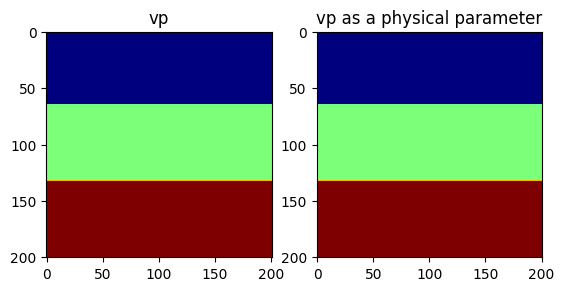

PyObject Text(0.5, 1.0, 'vp as a physical parameter')

In [4]:
figure()
subplot(121)
imshow(vp', cmap="jet")
title("vp")
subplot(122)
imshow(VP', cmap="jet")
title("vp as a physical parameter")

Because the physical parameter behaves as vector, we can easily perform standard operations on it.

In [5]:
norm(VP), extrema(VP), 2f0 .* VP, VP .^ 2

(411.6956f0, (1.5f0, 2.5f0), Float32[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], Float32[2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25  …  6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25])

## Model

JUDI then provide a `Model` structure that wraps multiple physical parameters toghether. A `Model` accept currently only accept standard Array as an input (**to be fixed #1**)

In [6]:
model = Model(shape, spacing, origin, vp)

Model((201, 201), (10.0, 10.0), (0.0, 0.0), 40, Dict{Symbol, PhysicalParameter{Float32}}(:m => [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]))

# Modeling 
Now that we have a seismic model, we will generate a few shot records.

## Acquisition Geometry
The first thing we need is an acquisiton geometry. In JUDI there is two ways to create a Geometry.
- By hand, as we will show here
- From a SEGY file, as we will show in a follow-up tutorial

We create a split-spread geomtry with sources at the top and receivers at the ocean bottom (top of second layer).

**Note**:
- JUDI currently expects all three coordinates to be inputed to setup a Geometry in 2D as well. This will be fixed in a later version of JUDI.

In [7]:
# Sources position
nsrc = 11
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

Now this definition creates a single Array of position, which would correspond to a single Simultenous source. Since we are interested in single source experiments here, we convert these position into an Array of Array
of size `nsrc` where each sub-array is a single source position

In [8]:
xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

In [9]:
# OBN position
nrec = 101
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (66*spacing[1])*ones(Float32, nrec);

The last step to be able to create and acquisiton geometry is to define a recording time and sampling rate

In [10]:
record_time = 4000f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

Now we can create the source and receivers geometry

In [11]:
src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

Let's visualize the geometry onto the model

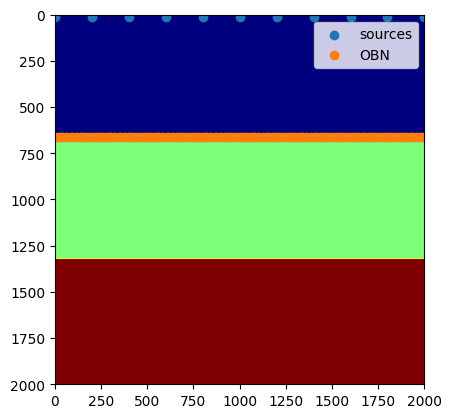

PyObject <matplotlib.legend.Legend object at 0x7ff3adfe7520>

In [12]:
figure();
imshow(vp', cmap="jet", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0])
scatter(xsrc, zsrc, label=:sources)
scatter(xrec, zrec, label="OBN")
legend()

### Source wavelet
For the source wavelet, we will use a standard Ricker wavelet at 10Hz for this tutorial.In practice this wavelet would be read from a file or estimated during inversion. 

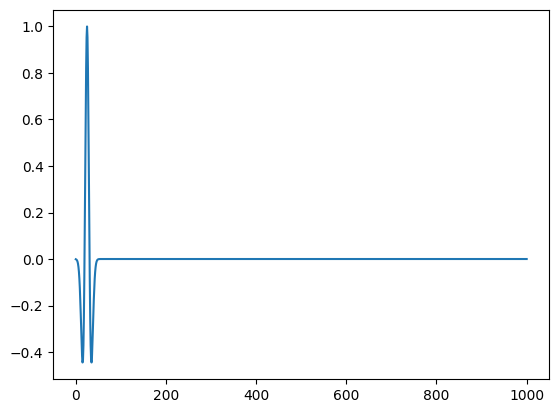

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff3adf65a90>

In [13]:
f0 = 0.010 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);
plot(wavelet)

## judiVector

In order to represent seismic data, JUDI provide the `judiVector` type. This type wraps a geometry with the seismic data corresponding to it. Let's cretae one for the source

In [14]:
q = judiVector(src_geom, wavelet)

judiVector{Float32, Matrix{Float32}}("Seismic data vector", 11011, 1, 11, GeometryIC{Float32}(Vector{Float32}[[0.0], [200.0], [400.0], [600.0], [800.0], [1000.0], [1200.0], [1400.0], [1600.0], [1800.0], [2000.0]], Vector{Float32}[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], Vector{Float32}[[12.5], [12.5], [12.5], [12.5], [12.5], [12.5], [12.5], [12.5], [12.5], [12.5], [12.5]], Float32[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], Integer[1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001], Float32[4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0]), Matrix{Float32}[[-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0; -0.0], [-0.00096925156; -0.0019277469; … ; -0.0

# Linear operator
The last step to model our seismic data os to create the linear operator representing the discretized wave equation on the Model we defined. We also need to define the linear operator corresponding to the source injection and the receiver interpolation.

In [16]:
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model) # Inverse of the disrete ewave equation.

judiModeling{Float32, Float32}("forward wave equation", 383971104, 383971104, Info(40401, 11, Integer[864, 864, 864, 864, 864, 864, 864, 864, 864, 864, 864]), Model((201, 201), (10.0, 10.0), (0.0, 0.0), 40, Dict{Symbol, PhysicalParameter{Float32}}(:m => [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])), Options(8, false, false, 1000.0, false, "", "shot", false, false, nothing, nothing, Any[], false, 1, 1, false, nothing), JUDI.var"#199#201"{Options, Model, UnitRange{Int64}}(Options(8, false, false, 1000.0, false, "", "shot", false, false, nothing, nothing, Any[], false, 1, 1, false, nothing), Model((201, 201), (10.0, 10.0), (0.0, 0.0), 40, Dict{Symbol, PhysicalParameter{Float32}}(:m => [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])), 1:11), JUDI.var"#200#202"{Options, Model, UnitRange{Int64}}(Options(8, false, false, 1000.0, false, "", "shot", false, false, nothing, nothing

**WARNING**
While these three operator are well defined in JUDI, `judiProjection` is a no-op operator and cannot be used by itself but only in combination with a `judiModeling` operator

# Seismic data

Now that we have all our operators setup we can finally generate synthetic data wit ha simple mat-vec product thanks to the abstraction

In [17]:
d_obs = Pr * Ainv * Ps' * q

judiVector{Float32, Matrix{Float32}}("F*q", 1112111, 1, 11, GeometryIC{Float32}(Vector{Float32}[[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0  …  1820.0, 1840.0, 1860.0, 1880.0, 1900.0, 1920.0, 1940.0, 1960.0, 1980.0, 2000.0], [0.0, 20.0

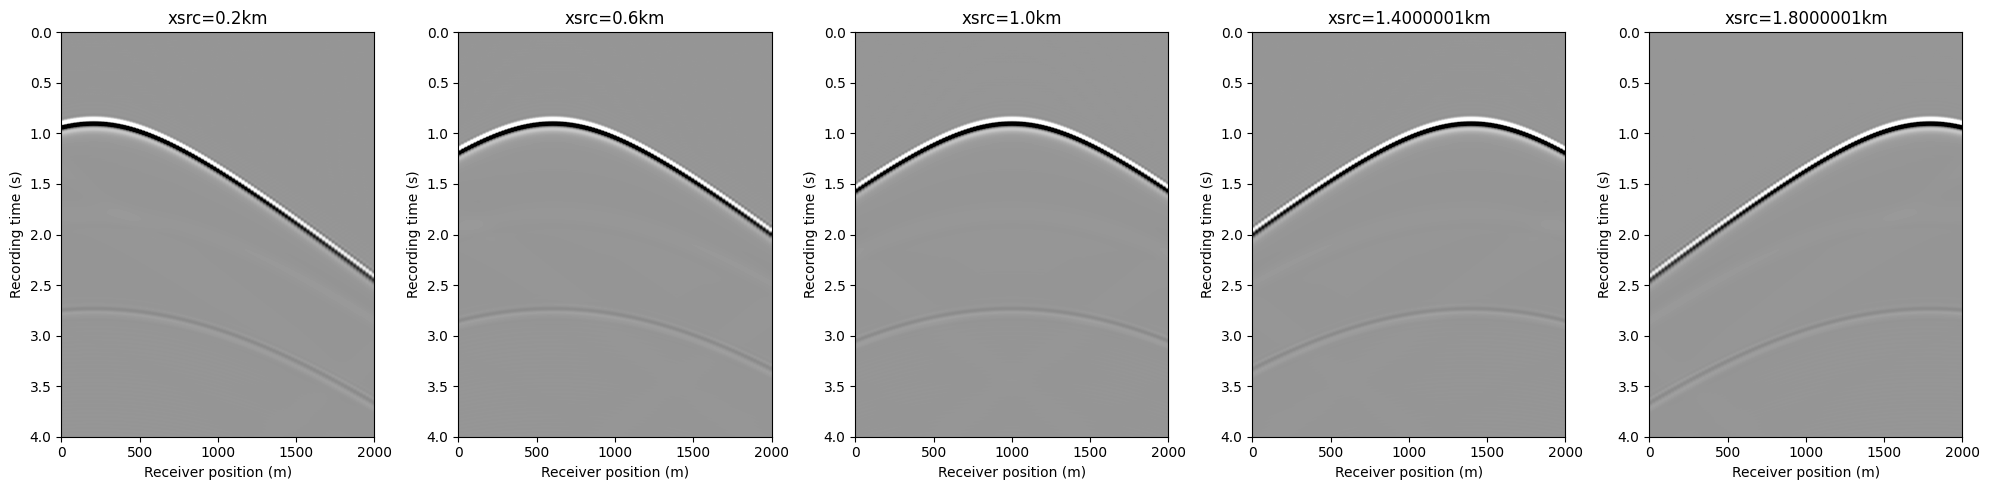

In [18]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 5))
for i=1:5
    subplot(1, 5, i)
    imshow(d_obs.data[2*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[2*i][1])km")
end
tight_layout()